In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [5]:
def calculate_multi_timeframe_confirmation(df, rsi_window=14):
    """
    多时间框架确认因子
    金融学原理：
    1. 4小时级别的超买确认增强15分钟信号有效性
    2. 量价背离检测（价格新高但RSI未新高）
    3. 实现跨周期验证，避免假信号
    """
    # 计算当前级别RSI
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    
    # 计算4小时级别RSI (假设当前是15分钟数据)
    ohlc_4h = df.resample('4H').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last'
    })
    ohlc_4h['rsi_4h'] = ta.rsi(ohlc_4h['close'], length=6)  # 4小时级别RSI
    ohlc_4h = ohlc_4h[['rsi_4h']]
    
    # 合并高级别数据
    df = df.join(ohlc_4h, how='left')
    df['rsi_4h'] = df['rsi_4h'].ffill()
    
    # 检测量价背离
    df['price_high'] = df['high'].rolling(5).max()
    df['rsi_high'] = df['rsi'].rolling(5).max()
    divergence = (df['high'] >= df['price_high']) & (df['rsi'] < df['rsi_high'])
    
    # 核心因子计算
    max_open_close = np.maximum(df['open'], df['close'])
    base_factor = (df['high'] - max_open_close) / df['open']
    
    # 信号增强
    return np.where(
        (df['rsi'] > 70) &
        (df['rsi_4h'] > 65) &
        divergence,
        base_factor * 2.0,
        base_factor
    )

# 因子测试

In [6]:
evaluator.set_factor(
    factor_data_or_func=calculate_multi_timeframe_confirmation,
    factor_name='calculate_multi_timeframe_confirmation'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.019484
   Rank_IC (Spearman): 0.012695
📊 信息比率:
   IR: 0.102236
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130731
   因子列: calculate_multi_timeframe_confirmation
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


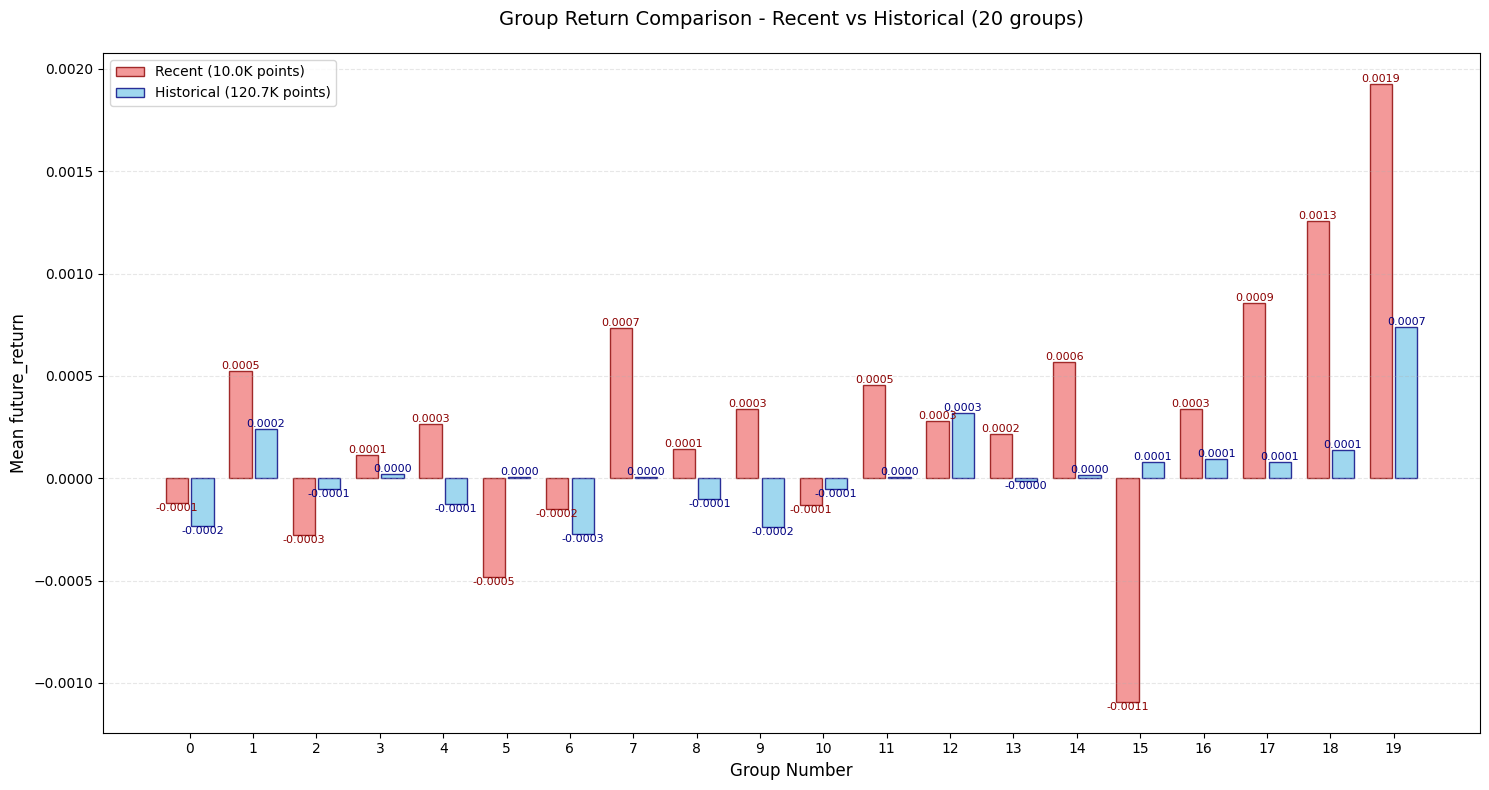

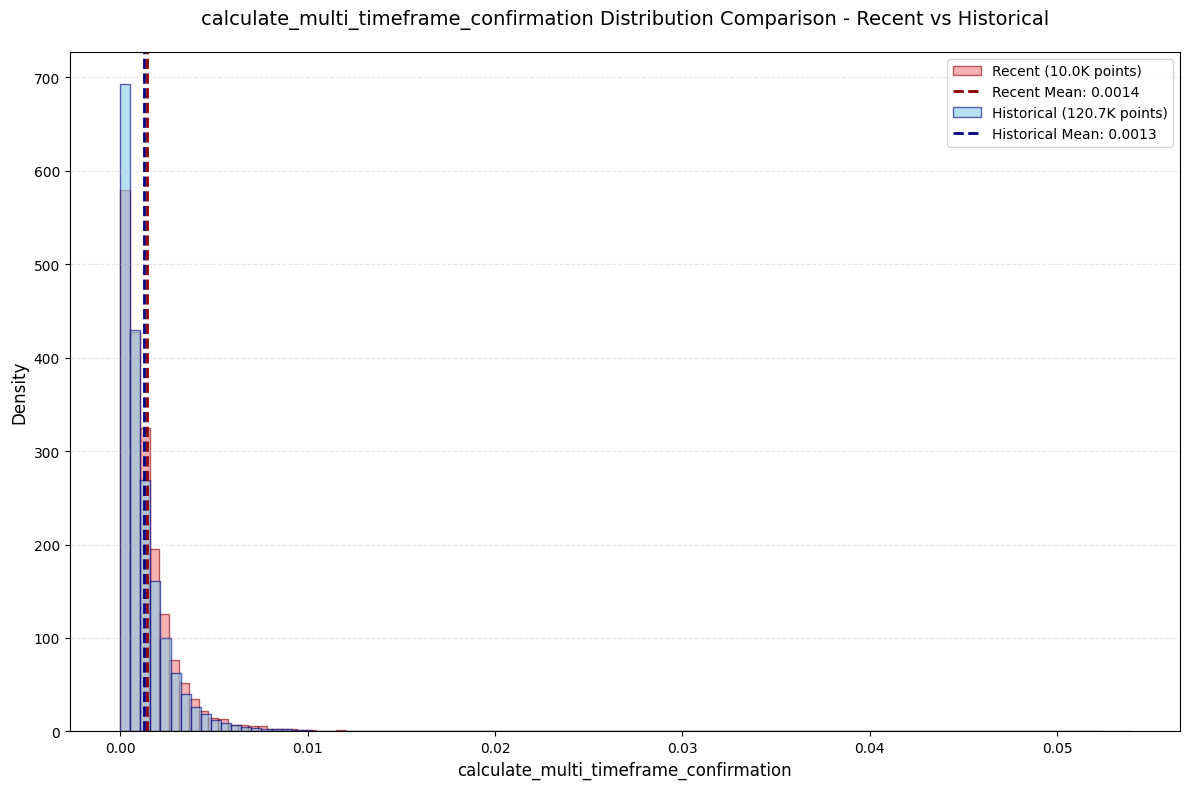

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [7]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)